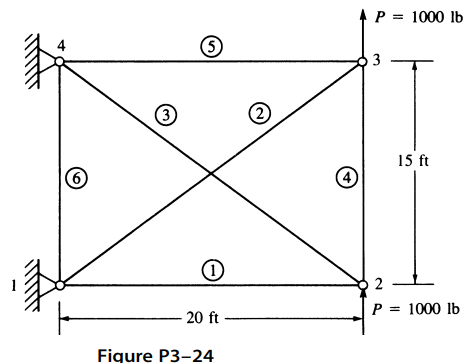

In [62]:
import numpy as np 
import pandas as pd 

In [63]:
columns = ['coordinate_x','coordinate_y','displacement_x','displacement_y','load_x','load_y']
data = [[0,0,0,0,np.nan,np.nan],
        [240,0,np.nan,np.nan,0,1000],
        [240,240,np.nan,np.nan,0,1000],
        [0,240,0,0,np.nan,np.nan]]
nodes = pd.DataFrame(data,columns=columns)
nodes

,coordinate_x,coordinate_y,displacement_x,displacement_y,load_x,load_y
0,0,0,0.0,0.0,NaN,NaN
1,240,0,NaN,NaN,0.0,1000.0
2,240,240,NaN,NaN,0.0,1000.0
3,0,240,0.0,0.0,NaN,NaN


In [64]:
columns = ['start','end','area','material']
data = [[0,1,2,30e6],
        [0,2,2,30e6],
        [1,3,2,30e6],
        [1,2,2,30e6],
        [2,3,2,30e6],
        [0,3,2,30e6],]
elements = pd.DataFrame(data,columns=columns)
elements

,start,end,area,material
0,0,1,2,30000000.0
1,0,2,2,30000000.0
2,1,3,2,30000000.0
3,1,2,2,30000000.0
4,2,3,2,30000000.0
5,0,3,2,30000000.0


In [65]:
def compute(element):
    start = element['start']
    end = element['end']

    startX = nodes.loc[start,'coordinate_x']
    endX = nodes.loc[end,'coordinate_x']
    deltaX = abs(endX - startX)

    startY = nodes.loc[start,'coordinate_y']
    endY = nodes.loc[end,'coordinate_y']
    deltaY = abs(endY - startY)

    length = np.sqrt(deltaX**2 + deltaY**2)

    stiffness = element['area']*element['material']/length

    c = deltaX/length
    s = deltaY/length
    
    k = np.array([[c*c, c*s, -c*c, -c*s],
                  [c*s, s*s, -c*s, -s*s],
                  [-c*c, -c*s, c*c, c*s],
                  [-c*s, -s*s, c*s, s*s]]).round(3)
    
    return length, stiffness, k, c, s
elements[['length','stiffness','k', 'cos', 'sin']] = elements.apply(compute, axis=1, result_type='expand')
elements.round(3)

,start,end,area,material,length,stiffness,k,cos,sin
0,0,1,2,30000000.0,240.000,250000.000,"[[1.0, 0.0, -1.0, -0.0], [0.0, 0.0, -0.0, -0.0...",1.000,0.000
1,0,2,2,30000000.0,339.411,176776.695,"[[0.5, 0.5, -0.5, -0.5], [0.5, 0.5, -0.5, -0.5...",0.707,0.707
2,1,3,2,30000000.0,339.411,176776.695,"[[0.5, 0.5, -0.5, -0.5], [0.5, 0.5, -0.5, -0.5...",0.707,0.707
3,1,2,2,30000000.0,240.000,250000.000,"[[0.0, 0.0, -0.0, -0.0], [0.0, 1.0, -0.0, -1.0...",0.000,1.000
4,2,3,2,30000000.0,240.000,250000.000,"[[1.0, 0.0, -1.0, -0.0], [0.0, 0.0, -0.0, -0.0...",1.000,0.000
5,0,3,2,30000000.0,240.000,250000.000,"[[0.0, 0.0, -0.0, -0.0], [0.0, 1.0, -0.0, -1.0...",0.000,1.000


In [66]:
def compute_globalK(element):
    N = len(nodes)
    indices = np.arange(N*2)
    indices = indices.reshape(-1,2)

    K = np.zeros([N*2,N*2])
    start = element['start']
    end = element['end']
    indices = np.hstack([indices[start],indices[end]])
    K[np.ix_(indices,indices)] = element['stiffness']*element['k']
    return K
K = elements.apply(compute_globalK, axis=1).sum()
K.round()

array([[ 338388.,   88388., -250000.,       0.,  -88388.,  -88388.,
              0.,       0.],
       [  88388.,  338388.,       0.,       0.,  -88388.,  -88388.,
              0., -250000.],
       [-250000.,       0.,  338388.,   88388.,       0.,       0.,
         -88388.,  -88388.],
       [      0.,       0.,   88388.,  338388.,       0., -250000.,
         -88388.,  -88388.],
       [ -88388.,  -88388.,       0.,       0.,  338388.,   88388.,
        -250000.,       0.],
       [ -88388.,  -88388.,       0., -250000.,   88388.,  338388.,
              0.,       0.],
       [      0.,       0.,  -88388.,  -88388., -250000.,       0.,
         338388.,   88388.],
       [      0., -250000.,  -88388.,  -88388.,       0.,       0.,
          88388.,  338388.]])

In [67]:
def partition_k(K, A, B):
    KAA = K[np.ix_(A,A)]
    KAB = K[np.ix_(A,B)]
    KBA = K[np.ix_(B,A)]
    KBB = K[np.ix_(B,B)]
    return KAA, KAB, KBA, KBB

U = nodes[['displacement_x','displacement_y']].to_numpy()
U = U.ravel()
A = np.isnan(U)

P = nodes[['load_x','load_y']].to_numpy()
P = P.ravel()
B = np.isnan(P)

KAA, KAB, KBA, KBB = partition_k(K, A, B)

In [68]:
# Known displacement, UB
UB = U[B]
# Known load, PA
PA = P[A]

UA = np.dot(np.linalg.inv(KAA),(PA - np.dot(KAB,UB)))
U[A] = UA

PB = np.dot(KBA,UA) + np.dot(KBB,UB)
P[B] = PB

In [69]:
results = nodes.copy()
results[['displacement_x','displacement_y']] = U.reshape(-1,2)
results[['load_x','load_y']] = P.reshape(-1,2)
results

,coordinate_x,coordinate_y,displacement_x,displacement_y,load_x,load_y
0,0,0,0.000,0.000000,2.273737e-13,-1000.0
1,240,0,-0.004,0.015314,0.000000e+00,1000.0
2,240,240,-0.004,0.015314,0.000000e+00,1000.0
3,0,240,0.000,0.000000,0.000000e+00,-1000.0


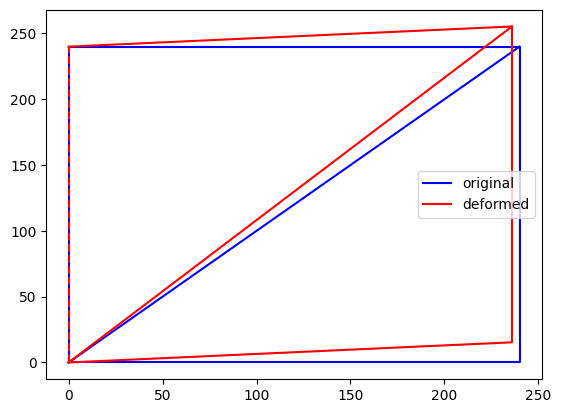

In [70]:
import matplotlib.pyplot as plt
factor = 1000
results['deformed_x'] = results['coordinate_x'] + factor*results['displacement_x']
results['deformed_y'] = results['coordinate_y'] + factor*results['displacement_y']

def original_fig():
    plt.plot(results['coordinate_x'],results['coordinate_y'],'b-',label='original')
    plt.plot(results.loc[[0,2],'coordinate_x'],results.loc[[0,2],'coordinate_y'],'b-')
    plt.plot(results.loc[[0,3],'coordinate_x'],results.loc[[0,3],'coordinate_y'],'b-')
original_fig()

def deformed_fig():
    plt.plot(results['deformed_x'],results['deformed_y'],'r-',label='deformed')
    plt.plot(results.loc[[0,2],'deformed_x'],results.loc[[0,2],'deformed_y'],'r-')
    plt.plot(results.loc[[0,3],'deformed_x'],results.loc[[0,3],'deformed_y'],'r--')
deformed_fig()
plt.legend()
# plt.axis('off')
plt.show()

In [71]:
def compute_stress(element):
    N = len(nodes)
    indices = np.arange(N*2)
    indices = indices.reshape(-1,2)
    start = element['start']
    end = element['end']
    indices = np.hstack([indices[start],indices[end]])
    d = U[np.ix_(indices)]
    c, s = element['cos'], element['sin']
    C = (element['material']/element['length'])*np.array([-c, -s, c, s])
    stress = np.dot(C,d)
    return stress.round(2)
elements['stress'] = elements.apply(compute_stress,axis=1)
elements

,start,end,area,material,length,stiffness,k,cos,sin,stress
0,0,1,2,30000000.0,240.000000,250000.000000,"[[1.0, 0.0, -1.0, -0.0], [0.0, 0.0, -0.0, -0.0...",1.000000,0.000000,-500.00
1,0,2,2,30000000.0,339.411255,176776.695297,"[[0.5, 0.5, -0.5, -0.5], [0.5, 0.5, -0.5, -0.5...",0.707107,0.707107,707.11
2,1,3,2,30000000.0,339.411255,176776.695297,"[[0.5, 0.5, -0.5, -0.5], [0.5, 0.5, -0.5, -0.5...",0.707107,0.707107,-707.11
3,1,2,2,30000000.0,240.000000,250000.000000,"[[0.0, 0.0, -0.0, -0.0], [0.0, 1.0, -0.0, -1.0...",0.000000,1.000000,-0.00
4,2,3,2,30000000.0,240.000000,250000.000000,"[[1.0, 0.0, -1.0, -0.0], [0.0, 0.0, -0.0, -0.0...",1.000000,0.000000,500.00
5,0,3,2,30000000.0,240.000000,250000.000000,"[[0.0, 0.0, -0.0, -0.0], [0.0, 1.0, -0.0, -1.0...",0.000000,1.000000,0.00
